<a href="https://colab.research.google.com/github/sajithperera/Angular-Course-Materials/blob/master/Market_Basket_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TDD Approach

In [ ]:
test_transactions = [
    ['bread', 'milk', 'butter'],
    ['bread', 'milk'],
    ['bread', 'butter'],
    ['milk', 'butter'],
    ['bread', 'milk', 'butter'],
    ['bread', 'jam']
]

# TESTS

# Test-01: Frequently bought items with bread
EXPECTED_BREAD_ASSOCIATIONS = {
    'milk': 3,
    'butter': 3,
    'jam': 1
}

# Test-02: 3 most frequent items
EXPECTED_TOP_PAIRS = [
    (('bread', 'milk'), 3),
    (('bread', 'butter'), 3),
    (('milk', 'butter'), 3)
]

# Test-03: Bread and milk bought together condition
EXPECTED_CO_PURCHASE = True

In [ ]:

# Build Data Structure


from collections import Counter
from itertools import combinations

def build_pair_support(test_transactions):
    test_pair_counter = Counter()

    for txn in test_transactions:
        for pair in combinations(sorted(txn), 2):
            test_pair_counter[pair] += 1

    return test_pair_counter

In [ ]:
#find items that are frequently bought with a given item
def items_bought_with(target_item, pair_support):
    test_result = {}

    for (item1, item2), count in pair_support.items():
        if item1 == target_item:
            test_result[item2] = count
        elif item2 == target_item:
            test_result[item1] = count

    return test_result

#top pairs return
def top_n_pairs(pair_support, n=2):
    return pair_support.most_common(n)

#check whether two items frequently bought together or not
def are_items_copurchased(item_a, item_b, pair_support, threshold=2):
    pair = tuple(sorted([item_a, item_b]))
    return pair_support.get(pair, 0) >= threshold

In [ ]:
#running the tests

pair_support = build_pair_support(test_transactions)

# Test-01
assert items_bought_with('bread', pair_support) == EXPECTED_BREAD_ASSOCIATIONS
print("✔ Test-01 Passed: Bread associations correct")

# Test-02
assert set(top_n_pairs(pair_support, 3)) == set(EXPECTED_TOP_PAIRS)
print("✔ Test-02 Passed: Top 3 pairs correct (order-independent)")

# Test-03
assert are_items_copurchased('bread', 'milk', pair_support) == EXPECTED_CO_PURCHASE
print("✔ Test-03 Passed: Co-purchase detection correct")




✔ Test-01 Passed: Bread associations correct


AssertionError: 

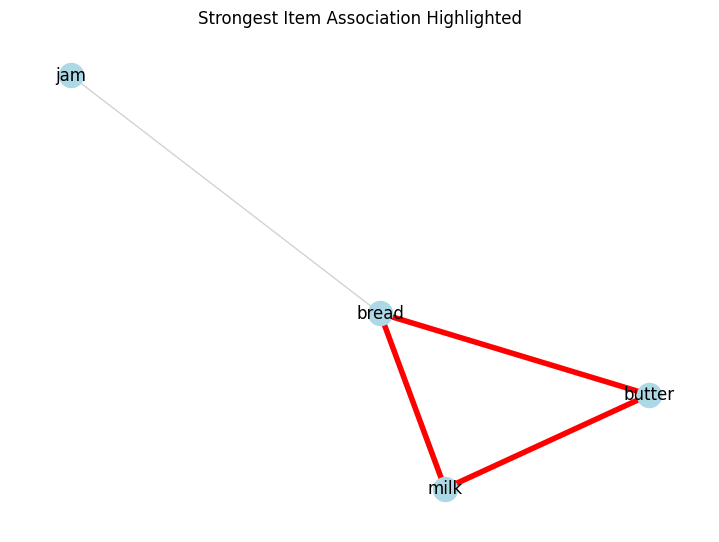

In [ ]:
#visualization for the above results

import networkx as nx
import matplotlib.pyplot as plt

# Build graph
G = nx.Graph()

for (i1, i2), support in pair_support.items():
    G.add_edge(i1, i2, weight=support)

# Find strongest bond
max_support = max(pair_support.values())
strong_edges = [
    (u, v) for u, v, d in G.edges(data=True)
    if d['weight'] == max_support
]

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(7, 5))

# Draw all edges (light)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='lightgray')

# Highlight strongest bond
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=strong_edges,
    width=4,
    edge_color='red'
)

plt.title("Strongest Item Association Highlighted")
plt.show()


# Monuting Google Drive


In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


# Removing Warnings in the Output

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Importing all the libraries needed

In [ ]:
#Installing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
from collections import Counter

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
read_df = pd.read_csv('/content/drive/MyDrive/MBA Assignment - Xeptagon/Supermarket_dataset_PAI.csv')
df = read_df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


In [ ]:
df.Member_number.nunique()

3898

In [ ]:
df.head()


,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [ ]:
#convert to same date format
# Convert Date to datetime (important)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# group the items purchased by the same member on same date
transactions = (
    df
    .groupby(['Member_number', 'Date'])['itemDescription']
    .apply(lambda x: list(set(x)))
    .reset_index()
)
transactions.head()

,Member_number,Date,itemDescription
0,1000,2014-06-24,"[whole milk, salty snack, pastry]"
1,1000,2015-03-15,"[sausage, semi-finished bread, yogurt, whole m..."
2,1000,2015-05-27,"[pickled vegetables, soda]"
3,1000,2015-07-24,"[misc. beverages, canned beer]"
4,1000,2015-11-25,"[sausage, hygiene articles]"


In [ ]:
df.itemDescription.nunique()

167

In [ ]:
#organizing the transactions separtely in to a list
allItems = transactions['itemDescription'].tolist()
print(allItems)

[['whole milk', 'salty snack', 'pastry'], ['sausage', 'semi-finished bread', 'yogurt', 'whole milk'], ['pickled vegetables', 'soda'], ['misc. beverages', 'canned beer'], ['sausage', 'hygiene articles'], ['sausage', 'rolls/buns', 'whole milk'], ['whole milk', 'soda'], ['frankfurter', 'whipped/sour cream', 'soda'], ['beef', 'white bread'], ['curd', 'frankfurter'], ['frozen vegetables', 'other vegetables'], ['whole milk', 'butter'], ['tropical fruit', 'sugar'], ['specialty chocolate', 'butter milk'], ['frozen meals', 'dental care'], ['rolls/buns'], ['detergent', 'root vegetables'], ['sausage', 'rolls/buns'], ['whole milk', 'tropical fruit', 'pip fruit'], ['cling film/bags', 'dish cleaner'], ['rolls/buns', 'red/blush wine', 'chocolate'], ['frozen fish', 'canned beer'], ['shopping bags', 'other vegetables'], ['whole milk', 'root vegetables', 'pastry'], ['whole milk', 'packaged fruit/vegetables', 'chocolate', 'rolls/buns'], ['other vegetables', 'hygiene articles'], ['rolls/buns'], ['margarin

In [ ]:
item_counts = Counter()

for t in allItems:
    item_counts.update(t)

print("Item frequencies:", item_counts)

Item frequencies: Counter({'whole milk': 2363, 'other vegetables': 1827, 'rolls/buns': 1646, 'soda': 1453, 'yogurt': 1285, 'root vegetables': 1041, 'tropical fruit': 1014, 'bottled water': 908, 'sausage': 903, 'citrus fruit': 795, 'pastry': 774, 'pip fruit': 734, 'shopping bags': 712, 'canned beer': 702, 'bottled beer': 678, 'whipped/sour cream': 654, 'newspapers': 582, 'frankfurter': 565, 'brown bread': 563, 'domestic eggs': 555, 'pork': 555, 'butter': 527, 'fruit/vegetable juice': 509, 'beef': 508, 'curd': 504, 'margarine': 482, 'coffee': 473, 'frozen vegetables': 419, 'chicken': 417, 'white bread': 359, 'cream cheese ': 354, 'chocolate': 353, 'dessert': 353, 'napkins': 331, 'hamburger meat': 327, 'berries': 326, 'UHT-milk': 320, 'onions': 303, 'salty snack': 281, 'waffles': 277, 'long life bakery product': 268, 'sugar': 265, 'butter milk': 263, 'ham': 256, 'meat': 252, 'frozen meals': 251, 'beverages': 248, 'specialty chocolate': 239, 'misc. beverages': 236, 'ice cream': 227, 'oil':

In [ ]:
#removing infrequent items
min_support_count = 2  # min_support in count
frequent_items = {item: cnt for item, cnt in item_counts.items() if cnt >= min_support_count}

print("Frequent items:", frequent_items)

Frequent items: {'whole milk': 2363, 'salty snack': 281, 'pastry': 774, 'sausage': 903, 'semi-finished bread': 142, 'yogurt': 1285, 'pickled vegetables': 134, 'soda': 1453, 'misc. beverages': 236, 'canned beer': 702, 'hygiene articles': 205, 'rolls/buns': 1646, 'frankfurter': 565, 'whipped/sour cream': 654, 'beef': 508, 'white bread': 359, 'curd': 504, 'frozen vegetables': 419, 'other vegetables': 1827, 'butter': 527, 'tropical fruit': 1014, 'sugar': 265, 'specialty chocolate': 239, 'butter milk': 263, 'frozen meals': 251, 'dental care': 33, 'detergent': 129, 'root vegetables': 1041, 'pip fruit': 734, 'cling film/bags': 74, 'dish cleaner': 73, 'red/blush wine': 157, 'chocolate': 353, 'frozen fish': 102, 'shopping bags': 712, 'packaged fruit/vegetables': 127, 'margarine': 482, 'rice': 49, 'bottled water': 908, 'softener': 41, 'skin care': 20, 'chicken': 417, 'bottled beer': 678, 'flour': 146, 'photo/film': 79, 'domestic eggs': 555, 'white wine': 175, 'liver loaf': 50, 'dessert': 353, 'h

In [ ]:
#sort the transactions
sorted_transactions = []

for t in allItems:
    filtered = [item for item in t if item in frequent_items]
    filtered.sort(key=lambda x: frequent_items[x], reverse=True)  # Descending frequency
    sorted_transactions.append(filtered)
print("Sorted transactions:", sorted_transactions)

Sorted transactions: [['whole milk', 'pastry', 'salty snack'], ['whole milk', 'yogurt', 'sausage', 'semi-finished bread'], ['soda', 'pickled vegetables'], ['canned beer', 'misc. beverages'], ['sausage', 'hygiene articles'], ['whole milk', 'rolls/buns', 'sausage'], ['whole milk', 'soda'], ['soda', 'whipped/sour cream', 'frankfurter'], ['beef', 'white bread'], ['frankfurter', 'curd'], ['other vegetables', 'frozen vegetables'], ['whole milk', 'butter'], ['tropical fruit', 'sugar'], ['butter milk', 'specialty chocolate'], ['frozen meals', 'dental care'], ['rolls/buns'], ['root vegetables', 'detergent'], ['rolls/buns', 'sausage'], ['whole milk', 'tropical fruit', 'pip fruit'], ['cling film/bags', 'dish cleaner'], ['rolls/buns', 'chocolate', 'red/blush wine'], ['canned beer', 'frozen fish'], ['other vegetables', 'shopping bags'], ['whole milk', 'root vegetables', 'pastry'], ['whole milk', 'rolls/buns', 'chocolate', 'packaged fruit/vegetables'], ['other vegetables', 'hygiene articles'], ['rol

In [ ]:
#showing the transactions with number of occurences

from collections import Counter

transaction_counts = Counter(tuple(txn) for txn in sorted_transactions)

print(f"Total unique transactions: {len(transaction_counts)}\n")

for txn, count in transaction_counts.items():
    print(f"Transaction: {list(txn)} → Count: {count}")

Total unique transactions: 7992

Transaction: ['whole milk', 'pastry', 'salty snack'] → Count: 1
Transaction: ['whole milk', 'yogurt', 'sausage', 'semi-finished bread'] → Count: 1
Transaction: ['soda', 'pickled vegetables'] → Count: 3
Transaction: ['canned beer', 'misc. beverages'] → Count: 2
Transaction: ['sausage', 'hygiene articles'] → Count: 2
Transaction: ['whole milk', 'rolls/buns', 'sausage'] → Count: 2
Transaction: ['whole milk', 'soda'] → Count: 48
Transaction: ['soda', 'whipped/sour cream', 'frankfurter'] → Count: 1
Transaction: ['beef', 'white bread'] → Count: 2
Transaction: ['frankfurter', 'curd'] → Count: 5
Transaction: ['other vegetables', 'frozen vegetables'] → Count: 15
Transaction: ['whole milk', 'butter'] → Count: 26
Transaction: ['tropical fruit', 'sugar'] → Count: 4
Transaction: ['butter milk', 'specialty chocolate'] → Count: 3
Transaction: ['frozen meals', 'dental care'] → Count: 2
Transaction: ['rolls/buns'] → Count: 24
Transaction: ['root vegetables', 'detergent'

# Build the FP Growth tree

In [ ]:
#build FP tree

class FPNode:
    def __init__(self):
        self.children = {}
        self.count = 0

# Initialize root
root = FPNode()

def insert_tree(items, node):
    for item in items:
        if item not in node.children:
            node.children[item] = FPNode()
        node = node.children[item]
        node.count += 1

# Insert all transactions
for t in sorted_transactions:
    insert_tree(t, root)

In [ ]:
#generate the visualisation of the FP tree

def print_tree(node, indent=0):
    for item, child in node.children.items():
        print(' ' * indent + f"{item}:{child.count}")
        print_tree(child, indent + 4)

print("Main FP-Tree:")
print_tree(root)

Main FP-Tree:
whole milk:2363
    pastry:54
        salty snack:2
            sugar:1
        shopping bags:2
            white bread:1
            chewing gum:1
        butter:2
            hair spray:1
        dog food:1
        napkins:3
            long life bakery product:1
        pork:1
            condensed milk:1
        beef:1
        fruit/vegetable juice:2
            hamburger meat:1
                frozen meals:1
        soft cheese:1
        curd:1
        canned beer:1
            beef:1
        newspapers:3
            fruit/vegetable juice:1
                coffee:1
                    processed cheese:1
                        baking powder:1
            white bread:1
            ham:1
                chewing gum:1
                    herbs:1
        specialty cheese:1
        specialty bar:1
        processed cheese:1
        margarine:1
        brown bread:1
            dessert:1
        dessert:1
        pip fruit:1
            coffee:1
                seasonal pr

# Generate Conditional Tree

In [ ]:
#build conditional tree
#which Items frequently bought with pastry
conditional_pattern_base = []

def find_paths(node, current_path):
    for item, child in node.children.items():
        new_path = current_path + [item]
        if item == 'pastry':
            conditional_pattern_base.append((current_path, child.count))
        find_paths(child, new_path)

find_paths(root, [])
print("Conditional Pattern Base for pastry:", conditional_pattern_base)


Conditional Pattern Base for pastry: [(['whole milk'], 54), (['whole milk', 'yogurt', 'sausage'], 1), (['whole milk', 'yogurt', 'tropical fruit'], 1), (['whole milk', 'yogurt'], 5), (['whole milk', 'rolls/buns', 'sausage'], 1), (['whole milk', 'rolls/buns', 'yogurt', 'sausage'], 1), (['whole milk', 'rolls/buns', 'citrus fruit'], 1), (['whole milk', 'rolls/buns', 'soda'], 1), (['whole milk', 'rolls/buns', 'root vegetables'], 1), (['whole milk', 'rolls/buns', 'tropical fruit'], 1), (['whole milk', 'rolls/buns'], 2), (['whole milk', 'soda', 'root vegetables', 'tropical fruit', 'bottled water'], 1), (['whole milk', 'soda', 'root vegetables'], 1), (['whole milk', 'soda', 'citrus fruit'], 1), (['whole milk', 'soda', 'bottled water'], 1), (['whole milk', 'soda', 'sausage'], 2), (['whole milk', 'soda'], 2), (['whole milk', 'tropical fruit'], 2), (['whole milk', 'tropical fruit', 'sausage'], 1), (['whole milk', 'root vegetables'], 2), (['whole milk', 'other vegetables'], 2), (['whole milk', 'ot

In [ ]:
#count the conditional frequencies
conditional_counts = Counter()

for path, count in conditional_pattern_base:
    for item in path:
        conditional_counts[item] += count

print("Conditional counts:", conditional_counts)

Conditional counts: Counter({'whole milk': 97, 'soda': 61, 'rolls/buns': 59, 'other vegetables': 55, 'yogurt': 54, 'sausage': 48, 'root vegetables': 43, 'bottled water': 43, 'tropical fruit': 42, 'citrus fruit': 32})


In [ ]:
#removing infrequent conditional FP -tree
conditional_frequent = {item: cnt for item, cnt in conditional_counts.items() if cnt >= min_support_count}
print("Conditional frequent items for pastry:", conditional_frequent)

Conditional frequent items for pastry: {'whole milk': 97, 'yogurt': 54, 'sausage': 48, 'tropical fruit': 42, 'rolls/buns': 59, 'citrus fruit': 32, 'soda': 61, 'root vegetables': 43, 'bottled water': 43, 'other vegetables': 55}


In [ ]:
pastry_root = FPNode()

for path, count in conditional_pattern_base:
    filtered = [i for i in path if i in conditional_frequent]
    filtered.sort(key=lambda x: conditional_frequent[x], reverse=True)

    node = pastry_root
    for item in filtered:
        if item not in node.children:
            node.children[item] = FPNode()
        node = node.children[item]
        node.count += count

print("Conditional FP-Tree for Pastry:")
print_tree(pastry_root)

Conditional FP-Tree for Pastry:
whole milk:97
    yogurt:7
        sausage:1
        tropical fruit:1
    rolls/buns:9
        sausage:1
        yogurt:1
            sausage:1
        citrus fruit:1
        root vegetables:1
        tropical fruit:1
        other vegetables:2
    soda:14
        rolls/buns:2
            other vegetables:1
                sausage:1
        root vegetables:2
            bottled water:1
                tropical fruit:1
        citrus fruit:1
        bottled water:1
        sausage:2
        other vegetables:4
            tropical fruit:1
                citrus fruit:1
            sausage:1
                bottled water:1
            yogurt:1
    tropical fruit:2
    sausage:4
        tropical fruit:1
    root vegetables:2
    other vegetables:3
        citrus fruit:1
    citrus fruit:1
    bottled water:1
soda:47
    yogurt:1
        bottled water:1
    tropical fruit:1
    sausage:4
        root vegetables:2
            tropical fruit:1
    root vegetabl

# Use Association Rules

Used mlxtend library implementation for FP growth for efficiency and scalability and to generate Association rules.

In [ ]:
# # Convert transactions to one-hot encoding
# import pandas as pd
te = TransactionEncoder()
te_array = te.fit(sorted_transactions).transform(sorted_transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

# FP-Growth
frequent_itemsets = fpgrowth(df_encoded, min_support=0.005, use_colnames=True)
print(frequent_itemsets)

# Association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.005)
print(rules)

      support                     itemsets
0    0.157923                 (whole milk)
1    0.051728                     (pastry)
2    0.018780                (salty snack)
3    0.085879                     (yogurt)
4    0.060349                    (sausage)
..        ...                          ...
121  0.007151   (whole milk, bottled beer)
122  0.005280  (whole milk, domestic eggs)
123  0.005614     (whole milk, newspapers)
124  0.007151   (whole milk, citrus fruit)
125  0.005012           (whole milk, pork)

[126 rows x 2 columns]
       antecedents     consequents  antecedent support  consequent support  \
0     (whole milk)        (pastry)            0.157923            0.051728   
1         (pastry)    (whole milk)            0.051728            0.157923   
2     (whole milk)        (yogurt)            0.157923            0.085879   
3         (yogurt)    (whole milk)            0.085879            0.157923   
4         (yogurt)          (soda)            0.085879            0.09

In [ ]:
# basket = transactions['itemDescription'].tolist()

te = TransactionEncoder()
te_array = te.fit(basket).transform(basket)

basket_df = pd.DataFrame(te_array, columns=te.columns_)
basket_df.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
frequent_itemsets = fpgrowth(
    basket_df,
    min_support=0.005,
    use_colnames=True
)

frequent_itemsets.sort_values('support', ascending=False)

,support,itemsets
0,0.157923,(whole milk)
17,0.122101,(other vegetables)
11,0.110005,(rolls/buns)
6,0.097106,(soda)
3,0.085879,(yogurt)
...,...,...
114,0.005280,"(root vegetables, soda)"
110,0.005213,"(yogurt, tropical fruit)"
106,0.005146,"(frankfurter, other vegetables)"
59,0.005012,(mayonnaise)


In [ ]:
#use the lift metric to filter out strong relationships

#change the
from mlxtend.frequent_patterns import association_rules

rules = association_rules(
    frequent_itemsets,
    metric='lift',
    min_threshold=1)

rules.sort_values('confidence', ascending=False).head(40)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
4,(frankfurter),(other vegetables),0.037760,0.122101,0.005146,0.136283,1.116150,1.0,0.000536,1.016420,0.108146,0.033261,0.016154,0.089214
2,(sausage),(soda),0.060349,0.097106,0.005948,0.098560,1.014975,1.0,0.000088,1.001613,0.015702,0.039259,0.001611,0.079906
0,(sausage),(yogurt),0.060349,0.085879,0.005748,0.095238,1.108986,1.0,0.000565,1.010345,0.104587,0.040913,0.010239,0.081082
1,(yogurt),(sausage),0.085879,0.060349,0.005748,0.066926,1.108986,1.0,0.000565,1.007049,0.107508,0.040913,0.007000,0.081082
3,(soda),(sausage),0.097106,0.060349,0.005948,0.061253,1.014975,1.0,0.000088,1.000963,0.016341,0.039259,0.000962,0.079906
5,(other vegetables),(frankfurter),0.122101,0.037760,0.005146,0.042146,1.116150,1.0,0.000536,1.004579,0.118536,0.033261,0.004558,0.089214


In [ ]:
#Q1
# use the item as sausage : What items bought with sausage

sausage_rules = rules[
    rules['antecedents'].apply(lambda x: 'sausage' in x) |
    rules['consequents'].apply(lambda x: 'sausage' in x)
]

sausage_rules.sort_values('confidence', ascending=False).head()


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
2,(sausage),(soda),0.060349,0.097106,0.005948,0.098560,1.014975,1.0,0.000088,1.001613,0.015702,0.039259,0.001611,0.079906
0,(sausage),(yogurt),0.060349,0.085879,0.005748,0.095238,1.108986,1.0,0.000565,1.010345,0.104587,0.040913,0.010239,0.081082
1,(yogurt),(sausage),0.085879,0.060349,0.005748,0.066926,1.108986,1.0,0.000565,1.007049,0.107508,0.040913,0.007000,0.081082
3,(soda),(sausage),0.097106,0.060349,0.005948,0.061253,1.014975,1.0,0.000088,1.000963,0.016341,0.039259,0.000962,0.079906


In [ ]:
#Q2 Two items oftern co-purchased
def list_all_copurchased_items(rules, min_conf=0.01):
    copurchased = set()

    for _, row in rules.iterrows():
        if row['confidence'] >= min_conf:
            for a in row['antecedents']:
                for c in row['consequents']:
                    copurchased.add((a, c))
                    copurchased.add((c, a))  # make it bidirectional

    return copurchased

copurchased_items = list_all_copurchased_items(rules, min_conf=0.01)

#only 20 pairs were taken can change this
for pair in list(copurchased_items)[:20]:
    print(pair)


('other vegetables', 'frankfurter')
('sausage', 'yogurt')
('soda', 'sausage')
('sausage', 'soda')
('frankfurter', 'other vegetables')
('yogurt', 'sausage')


Using the Manual generated FP tree Top pair were selected

In [ ]:
from collections import Counter
pair_counts = Counter()

for txn in sorted_transactions:
    for i in range(len(txn)):
        for j in range(i + 1, len(txn)):
            pair = tuple(sorted((txn[i], txn[j])))
            pair_counts[pair] += 1

total_txns = len(sorted_transactions)

pair_support = {
    pair: count / total_txns
    for pair, count in pair_counts.items()
}


top_pairs = sorted(
    pair_support.items(),
    key=lambda x: x[1],
    reverse=True
)[:20]
print(top_pairs)

[(('other vegetables', 'whole milk'), 0.014836596939116486), (('rolls/buns', 'whole milk'), 0.013967787208447505), (('soda', 'whole milk'), 0.011628684087415625), (('whole milk', 'yogurt'), 0.011160863463209249), (('other vegetables', 'rolls/buns'), 0.010559379803515338), (('other vegetables', 'soda'), 0.009690570072846355), (('sausage', 'whole milk'), 0.008955423377664907), (('tropical fruit', 'whole milk'), 0.008220276682483459), (('other vegetables', 'yogurt'), 0.008086613646995923), (('rolls/buns', 'soda'), 0.008086613646995923), (('rolls/buns', 'yogurt'), 0.007819287576020852), (('root vegetables', 'whole milk'), 0.00755196150504578), (('bottled beer', 'whole milk'), 0.007150972398583172), (('citrus fruit', 'whole milk'), 0.007150972398583172), (('bottled water', 'whole milk'), 0.007150972398583172), (('pip fruit', 'whole milk'), 0.006616320256633028), (('pastry', 'whole milk'), 0.006482657221145492), (('shopping bags', 'whole milk'), 0.006348994185657956), (('other vegetables', '

In [ ]:
# Convert top pairs to DataFrame to get better results
top_pairs_df = pd.DataFrame(
    [(pair[0], pair[1], support) for pair, support in top_pairs],
    columns=['Item 1', 'Item 2', 'Support']
)
top_pairs_df = top_pairs_df.sort_values(by='Support', ascending=False).reset_index(drop=True)
top_pairs_df

,Item 1,Item 2,Support
0,other vegetables,whole milk,0.014837
1,rolls/buns,whole milk,0.013968
2,soda,whole milk,0.011629
3,whole milk,yogurt,0.011161
4,other vegetables,rolls/buns,0.010559
5,other vegetables,soda,0.009691
6,sausage,whole milk,0.008955
7,tropical fruit,whole milk,0.008220
8,other vegetables,yogurt,0.008087
9,rolls/buns,soda,0.008087


# Graph Visualization

In [ ]:
# Keep only top 20 frequent pairs for clarity
top_pairs = frequent_pairs.head(20)

# Identify strongest bond (max support)
max_support = top_pairs['support'].max()

strongest_pairs = top_pairs[top_pairs['support'] == max_support]



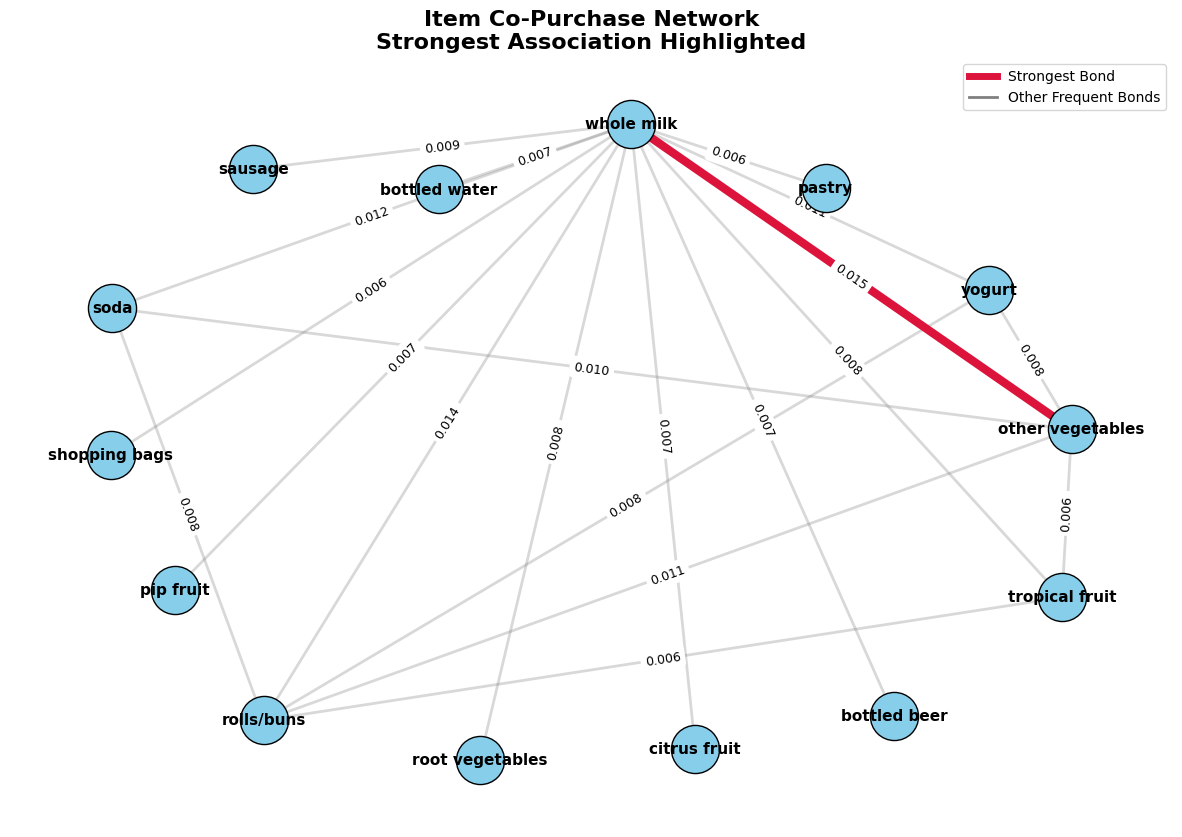

In [ ]:
#Q3 Graph Visualization highlighting the strongest bond

import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

# Add edges
for _, row in top_pairs.iterrows():
    i1, i2 = list(row['itemsets'])
    G.add_edge(i1, i2, weight=row['support'])

# Strongest edges
strongest_edges = [
    tuple(list(row['itemsets']))
    for _, row in strongest_pairs.iterrows()
]

pos = nx.spring_layout(G, seed=42, k=0.8)

plt.figure(figsize=(15, 10))

# Normal edges
normal_edges = [e for e in G.edges() if e not in strongest_edges]

nx.draw_networkx_edges(
    G,
    pos,
    edgelist=normal_edges,
    width=2,
    alpha=0.3,
    edge_color='gray'
)

# Strongest bond(s) — highlighted
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=strongest_edges,
    width=6,
    edge_color='crimson'
)

# Nodes
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=1200,
    node_color='skyblue',
    edgecolors='black'
)

# Labels
nx.draw_networkx_labels(
    G,
    pos,
    font_size=11,
    font_weight='bold'
)

# Edge labels (support)
edge_labels = {
    (u, v): f"{d['weight']:.3f}"
    for u, v, d in G.edges(data=True)
}

nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=edge_labels,
    font_size=9
)

plt.title(
    "Item Co-Purchase Network\nStrongest Association Highlighted",
    fontsize=16,
    fontweight='bold'
)

# Legend
import matplotlib.lines as mlines
strong_edge = mlines.Line2D([], [], color='crimson', linewidth=5, label='Strongest Bond')
normal_edge = mlines.Line2D([], [], color='gray', linewidth=2, label='Other Frequent Bonds')

plt.legend(handles=[strong_edge, normal_edge], loc='best')

plt.axis('off')
plt.show()
